## Packages

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.interpolate import UnivariateSpline
from sklearn.svm import SVC
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
url = "https://github.com/benard3360-star/Patient-Condition-Predict/raw/master/salaries%20(1).csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,MI,FT,Customer Success Manager,57000,EUR,60000,NL,50,NL,L
1,2025,SE,FT,Engineer,165000,USD,165000,US,0,US,M
2,2025,SE,FT,Engineer,109000,USD,109000,US,0,US,M
3,2025,SE,FT,Applied Scientist,294000,USD,294000,US,0,US,M
4,2025,SE,FT,Applied Scientist,137600,USD,137600,US,0,US,M


In [ ]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [ ]:
df.shape

(88584, 11)

In [ ]:
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


## EDA

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,88584.0,2024.034758,0.620370,2020.0,2024.00,2024.0,2024.0,2025.0
salary,88584.0,161932.290289,196531.718058,14000.0,106000.00,147000.0,199500.0,30400000.0
salary_in_usd,88584.0,157567.798417,73531.373158,15000.0,106097.25,146307.0,198600.0,800000.0
remote_ratio,88584.0,21.286011,40.831018,0.0,0.00,0.0,0.0,100.0


<Axes: xlabel='experience_level'>

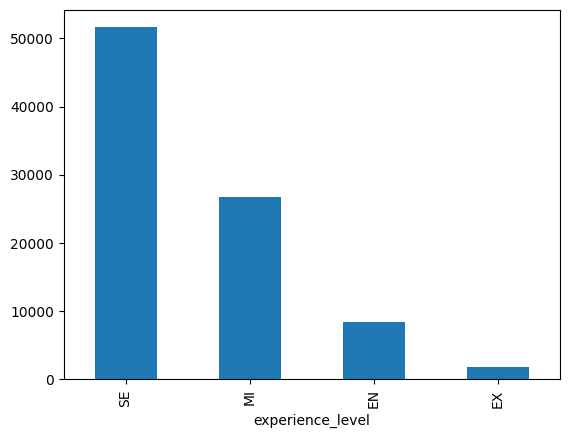

In [ ]:
df['experience_level'].value_counts().plot(kind='bar')

## Bivariate Analysis

## Geographical analysis

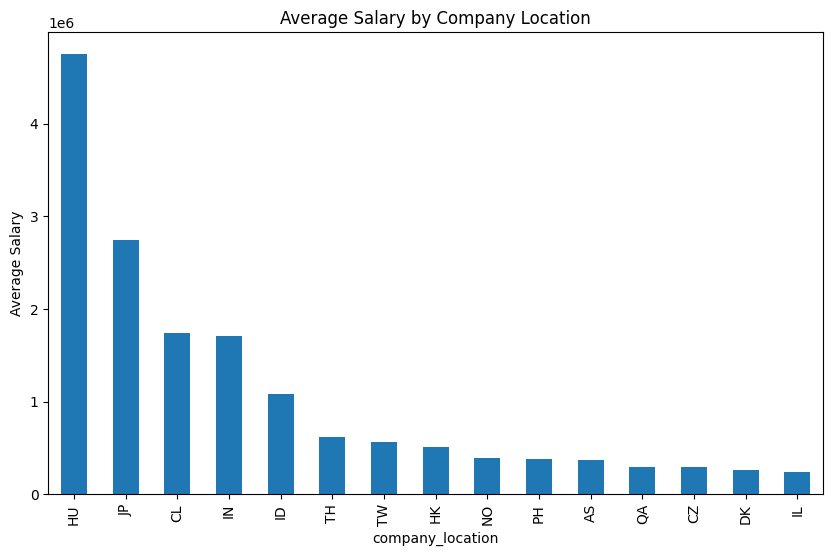

In [ ]:
plt.figure(figsize=(10, 6))
df.groupby('company_location')['salary'].mean().sort_values(ascending=False).head(15).plot(kind='bar')
plt.title('Average Salary by Company Location')
plt.ylabel('Average Salary')
plt.xticks(rotation=90)
plt.show()

## Trend over Years

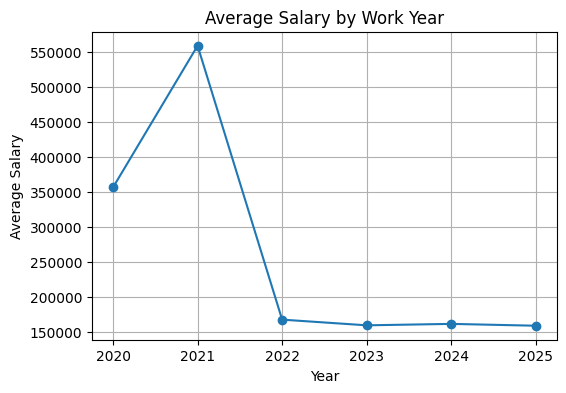

In [ ]:
plt.figure(figsize=(6, 4))
df.groupby('work_year')['salary'].mean().plot(marker='o')
plt.title('Average Salary by Work Year')
plt.ylabel('Average Salary')
plt.xlabel('Year')
plt.grid(True)
plt.show()


## Feature Engineering

In [ ]:
df['salary_band'] = pd.qcut(df['salary'], q=3, labels=['Low', 'Medium', 'High'])

In [ ]:
print(df['salary_band'].value_counts())

salary_band
Low       30186
High      29528
Medium    28870
Name: count, dtype: int64


## Check Distribution

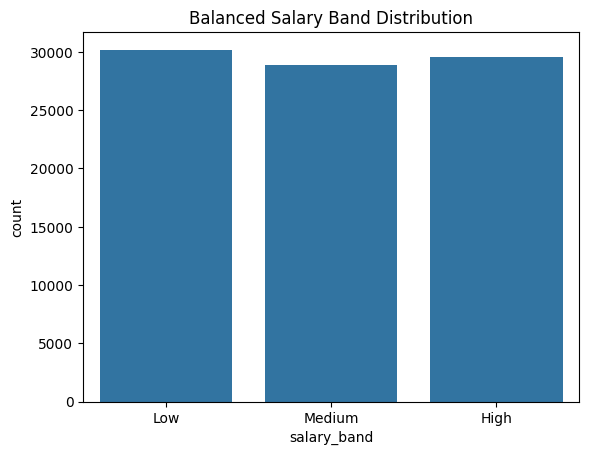

In [ ]:
sns.countplot(x='salary_band', data=df, order=['Low', 'Medium', 'High'])
plt.title('Balanced Salary Band Distribution')
plt.show()

## Inspect Salary Ranges for Each Band

In [ ]:
salary_ranges = df.groupby('salary_band')['salary'].agg(['min', 'max', 'mean'])
print(salary_ranges)

                min       max           mean
salary_band                                 
Low           14000    120000   86593.629066
Medium       120012    177778  148682.168202
High         177800  30400000  251904.650501


## Encode all object-type columns

In [ ]:
df_encoded = df.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

In [ ]:
le_band = LabelEncoder()
df_encoded['salary_band'] = le_band.fit_transform(df_encoded['salary_band'])
print(df_encoded['salary_band'].dtype)

int64


In [ ]:
df1=df_encoded.copy()

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88584 entries, 0 to 88583
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   work_year           88584 non-null  int64
 1   experience_level    88584 non-null  int64
 2   employment_type     88584 non-null  int64
 3   job_title           88584 non-null  int64
 4   salary              88584 non-null  int64
 5   salary_currency     88584 non-null  int64
 6   salary_in_usd       88584 non-null  int64
 7   employee_residence  88584 non-null  int64
 8   remote_ratio        88584 non-null  int64
 9   company_location    88584 non-null  int64
 10  company_size        88584 non-null  int64
 11  salary_band         88584 non-null  int64
dtypes: int64(12)
memory usage: 8.1 MB


## Define feature matrix and target

In [ ]:
X = df1.drop(columns=['salary', 'salary_in_usd', 'salary_band'])  # drop target + unused columns
y = df1['salary_band']

## Apply Forward Selection

In [ ]:
sfs = SequentialFeatureSelector(
    estimator=RandomForestClassifier(random_state=42),
    direction='forward',
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
sfs.fit(X, y)

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          n_jobs=-1, scoring='accuracy')

## Get selected features

In [ ]:
selected_features = X.columns[sfs.get_support()]
print("Selected Features:\n", list(selected_features))

Selected Features:
 ['experience_level', 'job_title', 'employee_residence', 'remote_ratio']


##Print summary statistics of selected features

In [ ]:
summary = df1[selected_features].describe()
print("\nSummary Statistics of Selected Features:\n", summary)


Summary Statistics of Selected Features:
        experience_level     job_title  employee_residence  remote_ratio
count      88584.000000  88584.000000        88584.000000  88584.000000
mean           2.372246    161.484309           82.828310     21.286011
std            0.918327     83.681143           19.402559     40.831018
min            0.000000      0.000000            0.000000      0.000000
25%            2.000000     99.000000           89.000000      0.000000
50%            3.000000    150.000000           89.000000      0.000000
75%            3.000000    226.000000           89.000000      0.000000
max            3.000000    311.000000           95.000000    100.000000


## Spearman correlation coefficients with target

In [ ]:
correlations = df1[selected_features].corrwith(y, method='spearman')
print("\n Spearman Correlation Coefficients with salary_band:\n", correlations)


 Spearman Correlation Coefficients with salary_band:
 experience_level     -0.071703
job_title            -0.126186
employee_residence   -0.018379
remote_ratio          0.049745
dtype: float64


## OLS Regression for t-statistics and p-values

In [ ]:
X_ols = sm.add_constant(df1[selected_features])
model_ols = sm.OLS(y, X_ols).fit()

## Combine correlation, t-stats, p-values into one DataFrame

In [ ]:
summary_df = pd.DataFrame({
    'Correlation': correlations,
    'T-Statistic': model_ols.tvalues[selected_features],
    'P-Value': model_ols.pvalues[selected_features]
})
print("\n Feature Summary Table:\n", summary_df)


 Feature Summary Table:
                     Correlation  T-Statistic        P-Value
experience_level      -0.071703   -14.585465   3.952901e-48
job_title             -0.126186   -33.139745  2.343049e-239
employee_residence    -0.018379    -3.225817   1.256591e-03
remote_ratio           0.049745    13.136639   2.210424e-39


In [ ]:
features = ['experience_level', 'job_title', 'employee_residence', 'remote_ratio']
X = df1[features]
y = df1['salary_band']

## Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define models

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

## Train and evaluate models


 Model: Logistic Regression
 Accuracy: 0.4865
 Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.59      0.53      5917
           1       0.56      0.58      0.57      5964
           2       0.38      0.28      0.33      5836

    accuracy                           0.49     17717
   macro avg       0.48      0.49      0.48     17717
weighted avg       0.48      0.49      0.48     17717



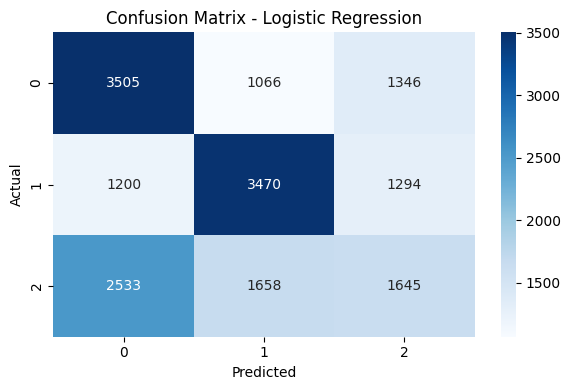


 Model: Random Forest
 Accuracy: 0.5301
 Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.67      0.58      5917
           1       0.63      0.64      0.63      5964
           2       0.40      0.28      0.33      5836

    accuracy                           0.53     17717
   macro avg       0.52      0.53      0.52     17717
weighted avg       0.52      0.53      0.52     17717



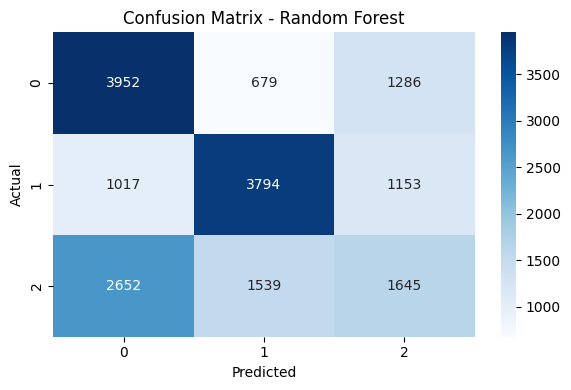


 Model: SVM
 Accuracy: 0.4571
 Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.66      0.53      5917
           1       0.49      0.62      0.55      5964
           2       0.36      0.09      0.14      5836

    accuracy                           0.46     17717
   macro avg       0.43      0.45      0.41     17717
weighted avg       0.43      0.46      0.41     17717



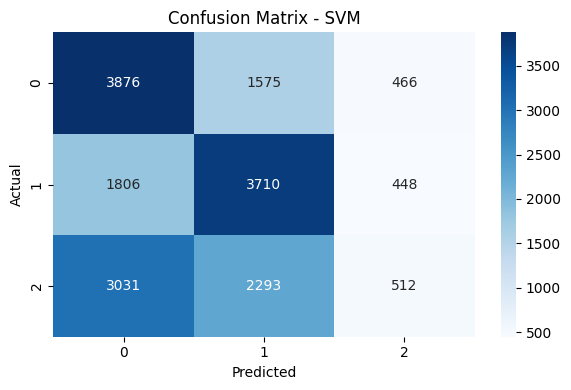


 Model: XGBoost
 Accuracy: 0.5306
 Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.67      0.59      5917
           1       0.62      0.66      0.64      5964
           2       0.40      0.26      0.31      5836

    accuracy                           0.53     17717
   macro avg       0.51      0.53      0.51     17717
weighted avg       0.51      0.53      0.51     17717



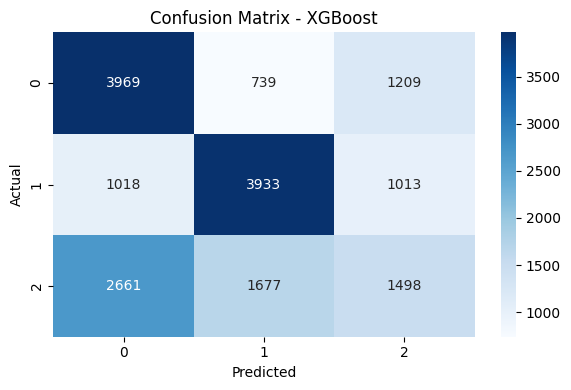

In [ ]:
for name, model in models.items():
    print(f"\n Model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f" Accuracy: {acc:.4f}")
    print(" Classification Report:\n", classification_report(y_test, y_pred))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

##  Train XGBoost with initial regularization

In [ ]:
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    reg_lambda=1.0,
    reg_alpha=0.5,
    random_state=42
)


In [ ]:
xgb_model.fit(X_train, y_train)
y_proba = xgb_model.predict_proba(X_test)

## Compute log loss

In [ ]:
logloss_value = log_loss(y_test, y_proba)
print(f" Log Loss (before smoothing): {logloss_value:.4f}")

 Log Loss (before smoothing): 0.9196


## Smooth log loss probabilities using Univariate Spline

In [ ]:
class_idx = 1
probs = y_proba[:, class_idx]

## Sort probabilities for smoother curve

In [ ]:
sorted_idx = np.argsort(probs)
x_vals = np.arange(len(probs))
y_vals = probs[sorted_idx]

## Apply smoothing spline

In [ ]:
spline = UnivariateSpline(x_vals, y_vals, s=0.5)
smooth_probs = spline(x_vals)

## Plot

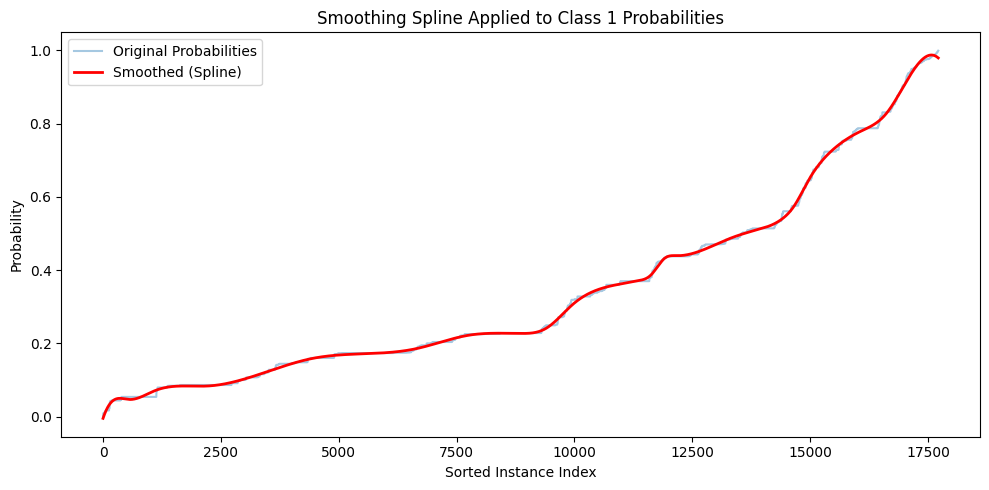

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x_vals, y_vals, label="Original Probabilities", alpha=0.4)
plt.plot(x_vals, smooth_probs, label="Smoothed (Spline)", color="red", linewidth=2)
plt.title("Smoothing Spline Applied to Class 1 Probabilities")
plt.xlabel("Sorted Instance Index")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()
plt.show()

## Predict salary bands (classes)

In [ ]:
y_pred = xgb_model.predict(X_test)
pred_df = pd.DataFrame({
    'Actual Salary Band': y_test,
    'Predicted Salary Band': y_pred
})

In [ ]:
print("Predicted vs Actual Salary Bands:\n")
print(pred_df.head(5))

Predicted vs Actual Salary Bands:

   Actual Salary Band  Predicted Salary Band
0                   0                      0
1                   2                      1
2                   1                      1
3                   2                      0
4                   1                      1


## **Note**
*   The model Struggles to Classify the salary in band 2

## Print classification report

In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.53      0.68      0.60      5906
           1       0.63      0.66      0.65      6037
           2       0.42      0.28      0.34      5774

    accuracy                           0.54     17717
   macro avg       0.53      0.54      0.53     17717
weighted avg       0.53      0.54      0.53     17717



## Save the trained XGBoost model to file

In [ ]:
import joblib
joblib.dump(xgb_model, 'xgboost_salary_band_model.pkl')
print("\nModel saved as 'xgboost_salary_band_model.pkl'")


Model saved as 'xgboost_salary_band_model.pkl'
